In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# 1. Pretrained AlexNet
model = models.alexnet(pretrained=True)
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])  # FC7까지 자르기
model.eval()

# 2. 이미지 전처리
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

# 3. 추출
def extract_feature(image_path):
    img = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        feature = model(input_tensor).squeeze().numpy()  # 4096-dim
    return feature

/Users/jeong-yonghun/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jeong-yonghun/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
random_dummy_image = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
dummy_image_path = 'dummy_image.jpg'
Image.fromarray(random_dummy_image).save(dummy_image_path)
feature_vector = extract_feature(dummy_image_path)
print("Feature vector shape:", feature_vector.shape)
print("Feature vector:", feature_vector)

Feature vector shape: (4096,)
Feature vector: [0. 0. 0. ... 0. 0. 0.]


In [15]:
import pandas as pd
import ast
from tqdm import tqdm

# 경로 설정
ID_MAPPING_PATH = "./data/baby/i_id_mapping.csv"
METADATA_PATH = "./data/baby/metadata.json"

# 헤더 없이 로드 (열이 하나만 있다고 가정)
i_id_mapping = pd.read_csv(ID_MAPPING_PATH, header=None, names=['asin', 'itemID'], sep='\t')
asin_sample = str(i_id_mapping.iloc[1]['asin']).strip()
print(f"확인할 asin: {asin_sample}")

# metadata 줄 수 계산
with open(METADATA_PATH, 'r') as f:
    total_lines = sum(1 for _ in f)

# metadata 검색
found = False
with open(METADATA_PATH, 'r') as f:
    for line in tqdm(f, total=total_lines, desc="Searching metadata"):
        try:
            item = ast.literal_eval(line.strip())
            if item.get('asin') == asin_sample:
                print(f"[✓] metadata에서 asin '{asin_sample}' 발견!")
                print(item)
                found = True
                break
        except Exception:
            continue

if not found:
    print(f"[X] metadata.json에서 asin '{asin_sample}' 을(를) 찾을 수 없습니다.")

확인할 asin: 097293751X


Searching metadata:  10%|█         | 954487/9430088 [00:53<07:52, 17953.29it/s]

[✓] metadata에서 asin '097293751X' 발견!
{'asin': '097293751X', 'categories': [['Baby']], 'description': "Easily keep track of your baby's or child's daily schedules, activities and needs in one handy spot.  And make the drop-off and pick-up process for childcare a snap.  The Baby Tracker Daily Childcare Journal is designed to make it fast and easy to record and review meals, naps, activities, playtime, daily news, milestones and to-dos ---all in a single page view.  Get ready for doctor visits, give to childcare helpers and use this easy at-a-glance daily record to monitor schedules and prep for your baby's daily needs.  This version records daily activities from 6 a.m. to 7 p.m. and creates a visual snapshot of activities by time each day.  \nThe Baby Tracker Daily Childcare Journal is ready to keep track of up to 6 months of daily schedule tracking (180 days) and is spiral bound to make it portable and lay flat for easy recording on a countertop or nightstand.Each journal includes:*180 

In [16]:
import pandas as pd
import ast
import json
from tqdm import tqdm

# 경로
ID_MAPPING_PATH = "./data/baby/i_id_mapping.csv"
METADATA_PATH = "./data/baby/metadata.json"

# asin 정제 (탭으로 분리된 파일이므로 sep='\t' 필요)
i_id_df = pd.read_csv(ID_MAPPING_PATH, sep='\t', header=None, names=['asin', 'itemID'])
baby_asins = set(i_id_df['asin'].astype(str).str.strip())

# metadata 줄 수 계산
with open(METADATA_PATH, 'r') as f:
    total_lines = sum(1 for _ in f)

# 필터링
baby_metadata = []
with open(METADATA_PATH, 'r') as f:
    for line in tqdm(f, total=total_lines, desc="Filtering metadata"):
        try:
            item = ast.literal_eval(line.strip())
            item_asin = str(item.get('asin', '')).strip()
            if item_asin in baby_asins:
                baby_metadata.append(item)
        except Exception:
            continue

print(f"Found {len(baby_metadata)} baby metadata items.")

# 저장
with open('./data/baby/metadata_baby.json', 'w') as f:
    json.dump(baby_metadata, f, indent=2)

Filtering metadata: 100%|██████████| 9430088/9430088 [09:58<00:00, 15769.33it/s]


Found 7050 baby metadata items.


ASIN: 097293751X
Title: Baby Tracker&reg; - Daily Childcare Journal, Schedule Log
Description: Easily keep track of your baby's or child's daily schedules, activities and needs in one handy spot.  And make the drop-off and pick-up process for childcare a snap.  The Baby Tracker Daily Childcare Journal is designed to make it fast and easy to record and review meals, naps, activities, playtime, daily news, milestones and to-dos ---all in a single page view.  Get ready for doctor visits, give to childcare helpers and use this easy at-a-glance daily record to monitor schedules and prep for your baby's daily needs.  This version records daily activities from 6 a.m. to 7 p.m. and creates a visual snapshot of activities by time each day.  
The Baby Tracker Daily Childcare Journal is ready to keep track of up to 6 months of daily schedule tracking (180 days) and is spiral bound to make it portable and lay flat for easy recording on a countertop or nightstand.Each journal includes:*180 daily at

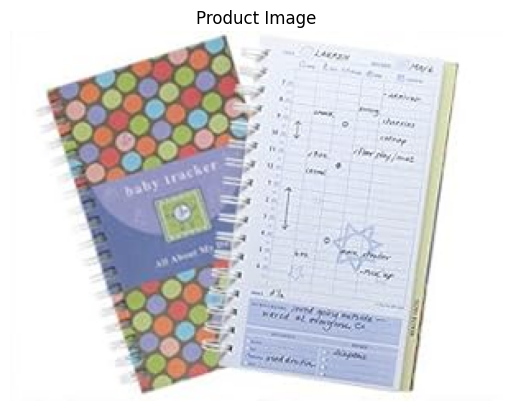

In [20]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# 경로 설정
METADATA_PATH = "./data/baby/metadata_baby.json"
ID_MAPPING_PATH = "./data/baby/i_id_mapping.csv"
IMAGE_FEAT_PATH = "./data/baby/image_feat.npy"
TEXT_FEAT_PATH = "./data/baby/text_feat.npy"

# 1. metadata 로드
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

# 2. asin 매핑 정보 로드
i_id_mapping = pd.read_csv(ID_MAPPING_PATH, sep='\t')  # 헤더 자동 인식
i_id_mapping['asin'] = i_id_mapping['asin'].astype(str).str.strip()
# 3. 벡터 로드
image_vectors = np.load(IMAGE_FEAT_PATH)
text_vectors = np.load(TEXT_FEAT_PATH)

# 4. 특정 index 예시로 출력 (예: 0번 item)
item_index = 0
asin = i_id_mapping.iloc[item_index]['asin']
item_meta = next((item for item in metadata if str(item.get('asin', '')).strip() == asin), None)

if item_meta is None:
    print(f"[X] Metadata not found for asin: {asin}")
else:
    print(f"ASIN: {asin}")
    print(f"Title: {item_meta.get('title', 'N/A')}")
    print(f"Description: {item_meta.get('description', 'N/A')}")
    print(f"Image URL: {item_meta.get('imUrl', 'N/A')}")

    print("\nText Vector (first 10 dims):")
    print(text_vectors[item_index][:10])

    print("\nImage Vector (first 10 dims):")
    print(image_vectors[item_index][:10])

    # 이미지 시각화
    try:
        response = requests.get(item_meta['imUrl'])
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Product Image")
        plt.show()
    except Exception as e:
        print(f"[!] 이미지 로딩 실패: {e}")

In [ ]:
from PIL import Image
import numpy as np
import torch
from torchvision import models, transforms
import requests
from io import BytesIO

model = models.alexnet(weights='IMAGENET1K_V1')
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])  
model.eval()

def preprocess_caffenet(image):
    image = image.resize((256, 256))
    image = image.crop((16, 16, 240, 240))  
    image = np.array(image).astype(np.float32)

    image = image[:, :, ::-1]  # RGB to BGR
    image = np.ascontiguousarray(image)

    mean = np.array([104, 117, 123], dtype=np.float32)
    image -= mean

    image = image.transpose((2, 0, 1))
    image_tensor = torch.from_numpy(image).unsqueeze(0)
    return image_tensor

def extract_caffenet_feature(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    input_tensor = preprocess_caffenet(image)
    with torch.no_grad():
        feature = model(input_tensor).squeeze().numpy()
    return feature

item_index = 0
image_url = item_meta['imUrl']
extracted_vector = extract_caffenet_feature(image_url)
saved_vector = image_vectors[item_index]

cosine_sim = np.dot(extracted_vector, saved_vector) / (
    np.linalg.norm(extracted_vector) * np.linalg.norm(saved_vector)
)
print(f"Cosine similarity: {cosine_sim:.6f}")

Cosine similarity: 0.053420


# 0625

ASIN: 097293751X
Title: Baby Tracker&reg; - Daily Childcare Journal, Schedule Log
Description: Easily keep track of your baby's or child's daily schedules, activities and needs in one handy spot.  And make the drop-off and pick-up process for childcare a snap.  The Baby Tracker Daily Childcare Journal is designed to make it fast and easy to record and review meals, naps, activities, playtime, daily news, milestones and to-dos ---all in a single page view.  Get ready for doctor visits, give to childcare helpers and use this easy at-a-glance daily record to monitor schedules and prep for your baby's daily needs.  This version records daily activities from 6 a.m. to 7 p.m. and creates a visual snapshot of activities by time each day.  
The Baby Tracker Daily Childcare Journal is ready to keep track of up to 6 months of daily schedule tracking (180 days) and is spiral bound to make it portable and lay flat for easy recording on a countertop or nightstand.Each journal includes:*180 daily at

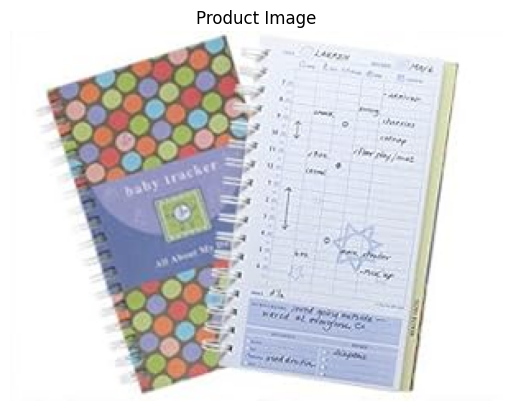

In [24]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# 경로 설정
METADATA_PATH = "./data/baby/metadata_baby.json"
ID_MAPPING_PATH = "./data/baby/i_id_mapping.csv"
IMAGE_FEAT_PATH = "./data/baby/image_feat.npy"
TEXT_FEAT_PATH = "./data/baby/text_feat.npy"

# 1. metadata 로드
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

# 2. asin 매핑 정보 로드
i_id_mapping = pd.read_csv(ID_MAPPING_PATH, sep='\t')  # 헤더 자동 인식
i_id_mapping['asin'] = i_id_mapping['asin'].astype(str).str.strip()
# 3. 벡터 로드
image_vectors = np.load(IMAGE_FEAT_PATH)
text_vectors = np.load(TEXT_FEAT_PATH)

# 4. 특정 index 예시로 출력 (예: 0번 item)
item_index = 0
asin = i_id_mapping.iloc[item_index]['asin']
item_meta = next((item for item in metadata if str(item.get('asin', '')).strip() == asin), None)

if item_meta is None:
    print(f"[X] Metadata not found for asin: {asin}")
else:
    print(f"ASIN: {asin}")
    print(f"Title: {item_meta.get('title', 'N/A')}")
    print(f"Description: {item_meta.get('description', 'N/A')}")
    print(f"Image URL: {item_meta.get('imUrl', 'N/A')}")

    print("\nText Vector (first 10 dims):")
    print(text_vectors[item_index][:10])

    print("\nImage Vector (first 10 dims):")
    print(image_vectors[item_index][:10])

    # 이미지 시각화
    try:
        response = requests.get(item_meta['imUrl'])
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Product Image")
        plt.show()
    except Exception as e:
        print(f"[!] 이미지 로딩 실패: {e}")

In [41]:
from torchvision import models, transforms
import torch
from PIL import Image, ImageDraw, ImageFont
import textwrap
import numpy as np

# 전체 AlexNet 모델 불러오기 (with classifier)
alexnet = models.alexnet(weights='IMAGENET1K_V1')
alexnet.classifier = torch.nn.Sequential(*list(alexnet.classifier.children())[:-1])  # 마지막 1000차원 FC 제거
alexnet.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 통계
                         std=[0.229, 0.224, 0.225]),
])

def text_to_image(text: str, font_size=24, image_size=(224, 224), max_lines=5):
    img = Image.new('RGB', image_size, color='white')
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()

    margin = 10
    wrapped = []
    for line in text.split('\n'):
        wrapped += textwrap.wrap(line, width=40)

    wrapped = wrapped[:max_lines]

    line_height = font.getbbox("A")[3]
    total_text_height = line_height * len(wrapped)
    y_start = (image_size[1] - total_text_height) // 2

    for i, line in enumerate(wrapped):
        line_width = font.getlength(line)
        x = (image_size[0] - line_width) // 2
        y = y_start + i * line_height
        draw.text((x, y), line, fill='black', font=font)

    return img

def extract_v_prime(text: str):
    img = text_to_image(text)
    input_tensor = preprocess(img).unsqueeze(0)

    with torch.no_grad():
        features = alexnet(input_tensor).squeeze().numpy()  # shape: (4096,)
    return features

In [43]:
item_index = 0
asin = i_id_mapping.iloc[item_index]['asin']
item_meta = next((item for item in metadata if str(item.get('asin', '')).strip() == asin), None)

# test text_to_image
text = item_meta.get('title', 'No Title')
img = text_to_image(text)
img.show()  # 이미지 확인

python(96160) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96185) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


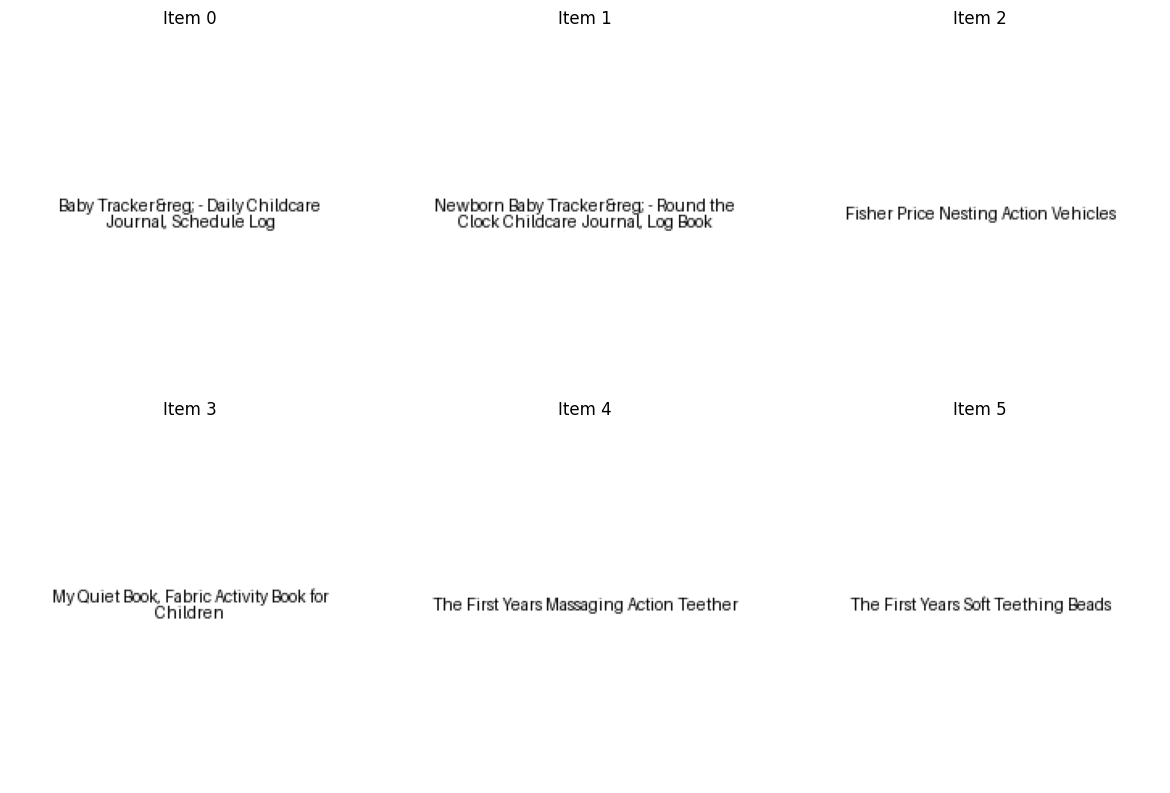

In [44]:
import matplotlib.pyplot as plt

def show_multiple_text_images(items, cols=3, font_size=24):
    rows = (len(items) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

    for i, item in enumerate(items):
        text = item.get('title', 'No Title')
        img = text_to_image(text, font_size=font_size)

        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Item {i}", fontsize=12)

    # 빈 칸 제거
    for j in range(len(items), rows * cols):
        ax = axes[j // cols, j % cols] if rows > 1 else axes[j % cols]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 예시: item_meta_list를 6개 가져와서 시각화
item_meta_list = []
for i in range(6):
    asin = i_id_mapping.iloc[i]['asin']
    meta = next((item for item in metadata if str(item.get('asin', '')).strip() == asin), None)
    item_meta_list.append(meta)

# 시각화
show_multiple_text_images(item_meta_list)

In [34]:
import random

def get_random_text(i, metadata, i_id_mapping):
    n_items = len(metadata)
    while True:
        rand_idx = random.randint(0, n_items - 1)
        if rand_idx != i:
            rand_asin = i_id_mapping.iloc[rand_idx]['asin']
            rand_meta = next((m for m in metadata if m['asin'] == rand_asin), None)
            if rand_meta:
                return rand_meta.get('title', '') + " " + rand_meta.get('description', '')

In [ ]:
t_prime_vectors = []
v_prime_vectors = []
t_prime_texts = []

n_items = len(image_vectors)

for i in tqdm(range(n_items), desc="Generating E^{t'} and E^{v'}"):
    # 랜덤한 다른 index 선택
    while True:
        rand_idx = random.randint(0, n_items - 1)
        if rand_idx != i:
            break

    # E^{t'} = 다른 아이템의 텍스트 벡터
    t_prime_vectors.append(text_vectors[rand_idx])

    # 원문 텍스트도 기록 (optional)
    rand_asin = i_id_mapping.iloc[rand_idx]['asin']
    rand_meta = next((m for m in metadata if m['asin'] == rand_asin), None)
    t_prime_text = rand_meta.get('title', '') + " " + rand_meta.get('description', '')
    t_prime_texts.append(t_prime_text)

    # E^{v'} = t′을 이미지로 만들고 AlexNet으로 임베딩
    v_prime = extract_v_prime(t_prime_text)
    v_prime_vectors.append(v_prime)

# shape 확인
print(f"t_prime_vectors shape: {np.array(t_prime_vectors).shape}")  
print(f"v_prime_vectors shape: {np.array(v_prime_vectors).shape}") 
print(f"vision_feat shape: {image_vectors.shape}")  
print(f"text_feat shape: {text_vectors.shape}")  

np.save('./data/baby/t_prime_feat.npy', np.stack(t_prime_vectors))  
np.save('./data/baby/v_prime_feat.npy', np.stack(v_prime_vectors))  
with open('./data/baby/t_prime_texts.json', 'w') as f:
    json.dump(t_prime_texts, f, indent=2, ensure_ascii=False)

Generating E^{t'} and E^{v'}: 100%|██████████| 7050/7050 [01:37<00:00, 72.12it/s]


t_prime_vectors shape: (7050, 384)
v_prime_vectors shape: (7050, 4096)
vision_feat shape: (7050, 4096)
text_feat shape: (7050, 384)


In [40]:
# numpy 배열 로드
vision_feat = np.load('./data/baby/image_feat.npy')          # [7050, 4096]
v_prime_feat = np.load('./data/baby/v_prime_feat.npy')        # [7050, 4096]

# 확인 후 생성
assert vision_feat.shape == v_prime_feat.shape  # 안전검사
typographic_feat = vision_feat + v_prime_feat   # element-wise sum

# 저장
np.save('./data/baby/typographic_feat.npy', typographic_feat)
print(f"Saved typographic_feat.npy with shape {typographic_feat.shape}")

Saved typographic_feat.npy with shape (7050, 4096)
